# Simple neural net tutorial

In this notebook, we will program a 2 layer neural network. It will classify two dimensional data into two classes.

![Simple neural network](graphics/simple_nn.png)


The first layer will contain $q$ neurons and the second one $r$. Thus:

- $\mathbf{x}$ is a vector containing two elements;
- $\mathbf{W}_1$ is a matrix of size $(q, 2)$ and $\mathbf{b}_1$ a vector of size $q$;
- $\mathbf{W}_2$ is a matrix of size $(r, 2)$ and $\mathbf{b}_2$ a vector of size $r$.

In [556]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Magic used by the notebook to show figures inline
%matplotlib inline
# matplotlib default values
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading packages
%load_ext autoreload
%autoreload 2

random_seed = 4

import sys
print("Python version:", sys.version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
('Python version:', '2.7.12 (default, Nov 20 2017, 18:23:56) \n[GCC 5.4.0 20160609]')


## Data for classification problems

The data below correspond to classification problems. Each input dataset $\mathbf{X}$ contains points of $\mathbb{R}^2$. The output datasets $\mathbf{y}$ give one of two classes, coded as $0$ or $1$, to each point.


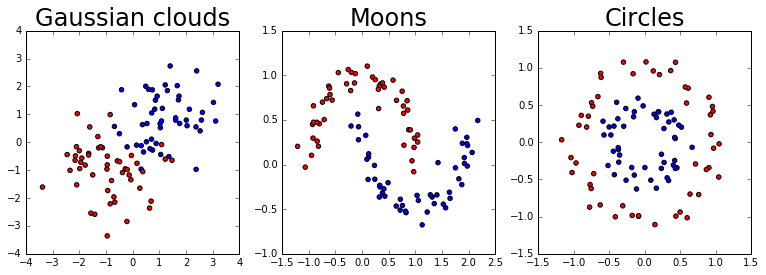

In [431]:
# Load and display data
from sklearn.datasets import make_moons, make_circles, make_blobs

figure = plt.figure(figsize=(13, 4))
cm = plt.cm.RdBu
cm_red_blue = ListedColormap(['#FF0000', '#0000FF'])

# Linearly separable
X_lin, y_lin = make_blobs(n_features=2, random_state=random_seed, centers=[[-1, -1], [1, 1]])
ax = plt.subplot(1, 3, 1)
ax.set_title("Gaussian clouds", fontsize=24)
ax.scatter(X_lin[:, 0], X_lin[:, 1], c=y_lin, cmap=cm_red_blue,
               edgecolors='k')

# Moons
X_moons, y_moons = make_moons(noise=0.1, random_state=random_seed)
ax = plt.subplot(1, 3, 2)
ax.set_title("Moons", fontsize=24)
ax.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=cm_red_blue,
               edgecolors='k')

# Circles (factor: ratio between inner and outer circles radius)
X_circ, y_circ = make_circles(noise=0.1, factor=0.5, random_state=random_seed)
ax = plt.subplot(1, 3, 3)
ax.set_title("Circles", fontsize=24)
ax.scatter(X_circ[:, 0], X_circ[:, 1], c=y_circ, cmap=cm_red_blue,
               edgecolors='k')

datasets = {"lin": [X_lin, y_lin], "circ": [X_circ, y_circ], "moons": [X_moons, y_moons]}

plt.show()
   

In [500]:
# Chosing the data set that will be used in the following
my_set = "moons"  # can be any of "lin", "circ" or "moons"
X_sel = datasets[my_set][0]
y_sel = datasets[my_set][1]


In [554]:
class SimpleNeuralNet(object):
    """Two-layer neural network, with two inputs and one output.
    """
    
    def __init__(self, q, r, act1, act2, random_state=None, sigma=0.01):
        """Neural network initialization.
        
        Arguments:
           q, r: number of neurons in the each layer.
           act1, act2: classes from activations.py used to instantiate the first and second activations.
           random_state: any real value. None means that no random seed is given.
           sigma: standard deviation of the normal random variable used for initializing the weights
           
        Returns:
            None
        """
        np.random.seed(random_state)
        self.sigma = sigma
        self.activation1 = act1()
        self.activation2 = act2()

        self.W1 = np.random.randn(q, 2) * self.sigma
        self.b1 = np.random.rand(q)
        self.W2 = np.random.randn(r, q) * self.sigma
        self.b2 = np.random.rand(r)

        self.dl_dy2 = None
        self.dl_dt2 = None
        self.dl_dW2 = None
        self.dl_db2 = None
        self.dl_dy1 = None
        self.dl_dt1 = None
        self.dl_dW1 = None
        self.dl_db1 = None

        
    def predict(self, x):
        """Compute NN prediction.
        
        x: numpy array containing 2 elements.
        """
        t1 = np.matmul(self.W1, x) + self.b1
        y1 = self.activation1(t1)
        t2 = np.matmul(self.W2, y1) + self.b2
        y2 = self.activation2(t2)
        
        return y2

    
    def forward_back_propagation(self, x, y_gt, learning_rate, verbose=False):
        """Forward pass, backward pass with parameters update, on a single sample.
        
        x: numpy array containing a single training sample (two coordinates).
        y_gt: expected output (ground-truth).
        learning_rate: positive real value, typically smaller than 1.
        verbose: toggles verbose mode
        
        Returns:
        l: loss value for the given input (before back propagation)
        """
        # Compute forward pass and local gradients
        t1 = np.matmul(self.W1, x) + self.b1
        dt1_dW1_transp = x
        dt1_db1 = np.full(q, 1)

        y1 = self.activation1(t1)
        dy1_dt1 = self.activation1.grad(t1)
        
        t2 = np.matmul(self.W2, y1) + self.b2
        dt2_dy1 = self.W2
        dt2_dW2_transp = y1
        dt2_db2 = np.full(r, 1)

        y2 = self.activation2(t2)
        dy2_dt2 = self.activation2.grad(t2)
        
        l = np.square(y2 - y_gt).sum() # Note: this value is not used in the optimization. It is only returned by the function.
        if verbose is True: print("Predicted output (y): ", y)
        
        # Back propagate gradient
        self.dl_dy2 = 2 * (y2 - y_gt)
        self.dl_dt2 = self.dl_dy2 * dy2_dt2
        self.dl_dW2 = np.matmul(self.dl_dt2[..., np.newaxis], dt2_dW2_transp[np.newaxis,...])  # Waiting for @
        self.dl_db2 = self.dl_dt2
        self.dl_dy1 = np.matmul(self.dl_dt2, dt2_dy1)
        self.dl_dt1 = self.dl_dy1 * dy1_dt1
        self.dl_dW1 = (np.matmul(self.dl_dt1[..., np.newaxis], dt1_dW1_transp[np.newaxis,...]))
        self.dl_db1 = self.dl_dy1 * dy1_dt1
        
        # Update parameters
        self.b1 = self.b1 - learning_rate * self.dl_db1
        self.W1 = self.W1 - learning_rate * self.dl_dW1
        self.b2 = self.b2 - learning_rate * self.dl_db2
        self.W2 = self.W2 - learning_rate * self.dl_dW2

        return l
    
    
    def fit(self, X, Y, epochs, learning_rate, verbose=False):
        """Learn model using gradient descent.
        
        X: input examples
        Y: output examples
        learning_rate: learning rate
        batch: size of mini-batch
        verbose: toggle verbose mode
        """
        loss_hist = []
        for epoch in range(epochs):
            epoch_loss_list = []
            for (x, y) in zip(X, Y):
                epoch_loss_list += [self.forward_back_propagation(x, y, learning_rate)]
            if verbose is True: print("Epoch ", epoch, " : loss = ", np.mean(epoch_loss_list))
            loss_hist += [np.mean(epoch_loss_list)]
                
        return loss_hist


In [502]:
from dlia_tools import activations

act1 = activations.ActivationRelu
act2 = activations.ActivationRelu

q = 8
r = 1

nn = SimpleNeuralNet(q, r, act1, act2, random_state=random_seed)

In [505]:
# Create grid for visualization
h = 0.1
x0_min = X_sel[:, 0].min() - h
x0_max = X_sel[:, 0].max() + h
x1_min = X_sel[:, 1].min() - h
x1_max = X_sel[:, 1].max() + h
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h))
xx0_ravel = xx0.ravel()
xx1_ravel = xx1.ravel()



('Mean loss: ', 0.088116233548108783)
('W1: ', array([[ 0.17267369, -0.53439411],
       [-1.03837305, -0.06625207],
       [ 0.19887609, -0.57497141],
       [-0.03298168,  2.08944684],
       [ 0.50292021, -0.56084773],
       [-0.64135598, -0.01378036],
       [-0.28710391,  0.09193771],
       [ 0.01280567,  0.4219749 ]]))
('W2 ', array([[ 0.0635562 , -0.91266571,  0.07012752, -0.4850577 ,  0.22668039,
        -0.55947421, -0.22912609, -0.09512586]]))
('b1:', array([-0.0037532 , -0.24149056, -0.01874446, -0.74435636, -0.37071669,
       -0.1680805 , -0.12139414, -0.05038382]))
('b2:', array([ 0.76954148]))


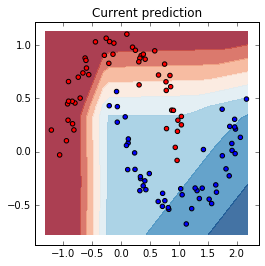

In [552]:
# Train a single epoch - look at the evolution of the model
loss = []
learning_rate = 0.1
for (x, y) in zip(X_sel, y_sel):
    loss += [nn.forward_back_propagation(x, y, learning_rate)]
print("Mean loss: ", np.mean(loss))
print("W1: ", nn.W1)
print("W2 ", nn.W2)
print("b1:", nn.b1)
print("b2:",  nn.b2)

# predict on all grid points
i = 0
y_pred_ravel = np.zeros(len(xx0_ravel))
for (x0, x1) in zip(xx0_ravel, xx1_ravel):
    y_pred_ravel[i] = nn.predict(np.array([x0, x1]))
    i += 1
y_pred = y_pred_ravel.reshape(xx0.shape)

# Plot current model
figure = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
ax.set_title("Current prediction")
ax.contourf(xx0, xx1, y_pred, cmap=cm, alpha=.8)
ax.scatter(X_sel[:, 0], X_sel[:, 1], c=y_sel, cmap=cm_red_blue,
               edgecolors='k')
plt.show()

('Final loss: ', 0.016663892080930255)


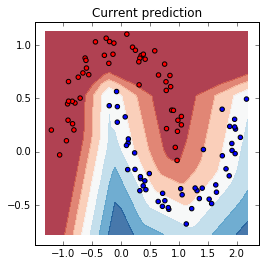

In [553]:
nn = SimpleNeuralNet(q, r, act1, act2, random_state=random_seed)

# Train N epochs
epochs = 200
learning_rate = 0.1
loss_hist = nn.fit(X_sel, y_sel, epochs, learning_rate)
print("Final loss: ", loss_hist[-1])

# predict on all grid points
i = 0
for (x0, x1) in zip(xx0_ravel, xx1_ravel):
    y_pred_ravel[i] = nn.predict(np.array([x0, x1]))
    i += 1
y_pred = y_pred_ravel.reshape(xx0.shape)

# Plot current model
figure = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
ax.set_title("Current prediction")
ax.contourf(xx0, xx1, y_pred, cmap=cm, alpha=.8)
ax.scatter(X_sel[:, 0], X_sel[:, 1], c=y_sel, cmap=cm_red_blue, edgecolors='k')
# ax.scatter(xx0, xx1, c=y_pred, cmap=cm_red_blue, edgecolors='k')
plt.show()

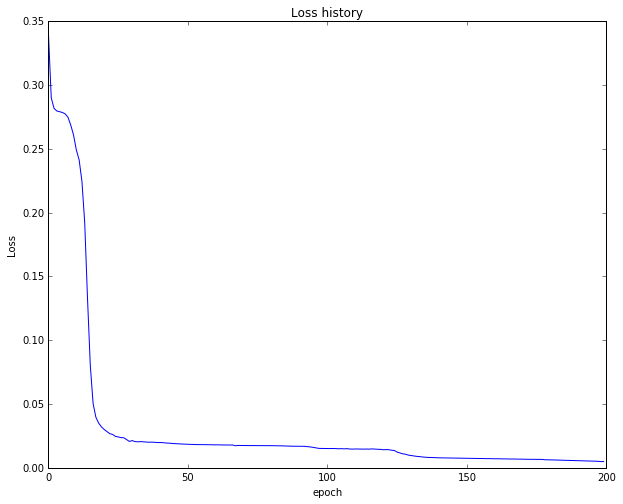

In [498]:
plt.plot(loss_hist)
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()